### 루브릭 평가 문항	상세 기준
1. 음성 데이터를 2 차원 스펙트로 그램으로 변환하여 데이터 셋을 구성했습니다.
   - 스펙트로 그램 구성 및 train / test 데이터 셋 구성이 정상 진행 예시.   

---
2. 1,2 차원 데이터를 처리하는 음성 인식 모델이 정상 작동한다.   
   - 스펙트로 그램을 입력받은 모델이 학습 과정에서 안정적으로 수렴하며, 평가 / 테스트 단계를 무리없이 진행 가능하다.
---
3. 테스트 셋 수행 결과 음성 인식 모델의 정확도가 일정 수준에 도달했습니다.
   - 평가 결과 75 % 이상의 존재한다.

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


## 1. 2차원 Spectrogram 데이터를 처리하는 모델 구성

In [2]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [3]:
empty_list = []
num=0
print("Wave data shape : ", speech_data["wav_vals"].shape)
for i in speech_data["wav_vals"] :
    empty_list.append(wav2spec(i))
specs = np.array(empty_list)    
print("✅")

Wave data shape :  (50620, 8000)
✅


In [4]:
print(specs.shape)

(50620, 130, 126)


## 2. target list 구성

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

## 3. 데이터 처리와 분류
### - 라벨 데이터 처리하기
### - sklearn의 train_test_split함수를 이용하여 train, test 분리

In [7]:
from sklearn.model_selection import train_test_split


train_wav, test_wav, train_label, test_label = train_test_split(specs, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)


train_wav = train_wav.reshape([-1, 130, 126, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, 130, 126, 1])
print("✅")

✅


In [8]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)
✅


## 3. 학습을 위한 하이퍼 파라미터 설정

In [9]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj17/aiffel/speech_recognition/models/wav'

## 4. 데이터셋 구성
- from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
- map과 batch를 이용한 데이터 전처리

In [10]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


## 5. tf.data.Dataset 함수를 구성
- batch는 dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수

In [11]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


## 6. 메모리 공간 확보하기

In [12]:
del specs

In [13]:
del speech_data

## 7. Wave classification 모델 구현
- Conv2D 사용
- Skip-connection 사용

In [14]:
from tensorflow.keras import layers
input_tensor = layers.Input(shape=(130,126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 130, 126, 32) 2624        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 130, 126, 32) 82976       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 65, 63, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [16]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


## 8. 학습
- 30분 정도 소요
- 메모리 오류로 인해 튕길 위험 있음

In [17]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
1423/1423 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.7720
Epoch 00001: val_loss improved from inf to 0.27660, saving model to /home/aiffel-dj17/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 236s 166ms/step - loss: 0.6954 - accuracy: 0.7720 - val_loss: 0.2766 - val_accuracy: 0.9094
Epoch 2/10
1423/1423 [==============================] - ETA: 0s - loss: 0.2028 - accuracy: 0.9349
Epoch 00002: val_loss improved from 0.27660 to 0.19225, saving model to /home/aiffel-dj17/aiffel/speech_recognition/models/wav_skip
1423/1423 [==============================] - 238s 167ms/step - loss: 0.2028 - accuracy: 0.9349 - val_loss: 0.1923 - val_accuracy: 0.9389
Epoch 3/10
1423/1423 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9576
Epoch 00003: val_loss improved from 0.19225 to 0.12919, saving model to /home/aiffel-dj17/aiffel/speech_recognition/models/wav_skip
1423/1423 [=============================

## 9. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
- Training and Validation loss, accuracy를 그래프로 표현

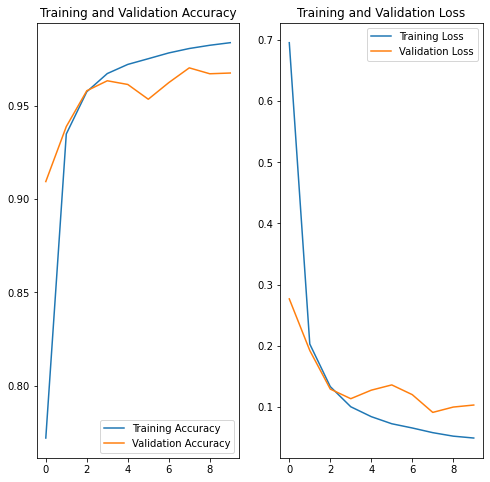

✅


In [18]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 10. Test dataset을 이용해서 모델의 성능을 평가
- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인
- accuracy value : 97.0367%
- loss value : 0.091

In [19]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

159/159 [==============================] - 27s 169ms/step - loss: 0.0909 - accuracy: 0.9704
loss value: 0.091
accuracy value: 97.0367%
✅


In [20]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

#ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  no


In [21]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: no(Correct!)
✅


## 마치며...
---
메모리 부족으로 자꾸 튕기는 일이 많아서 힘들었다. 그래도 2차원으로 변환하는 곳을 바꾸고 batch_size를 낮춰서 테스트하고 재부팅 하고 했더니 다행히 안튕기고 돌아갔다. 돌려놓고 잤는데 일어나서 결과가 나와있으니 행복했다. 그래서 다시 batch_size 올리고 실행해도 잘 돌아가서 다행이었다.

---

### 루브릭 평가 문항	상세 기준
---
1. 음성 데이터를 2차원 스펙트로그램으로 변환하여 데이터 셋을 구성했습니다.
   - 스펙트로 그램 구성 및 train / test 데이터 셋 구성이 정상 진행 예시.   
   ---
   - 2차원 스펙트로그램으로 변환하는 과정을 처음에는 [E1]rock_sissor_paper_classifier에 나오는 np.zeros를 생성한 후 np.reshape하는 과정으로 하고 split 함수를 이용하여 train, test 데이터셋을 구성했는데, model.fit 하는 과정에서 자꾸 메모리 문제로 튕겼다. 그래서 list.append로 바꾸고 batch_size를 조절했더니 메모리 문제가 해결되었다.
---
2. 1,2 차원 데이터를 처리하는 음성 인식 모델이 정상 작동한다.   
   - 스펙트로 그램을 입력받은 모델이 학습 과정에서 안정적으로 수렴하며, 평가 / 테스트 단계를 무리없이 진행 가능하다.
   ---
   - Training and Validation loss, accuracy를 그래프로 출력한 결과 안정적인 모습을 보였으며, 오류가 발생하지 않았다.
---
3. 테스트 셋 수행 결과 음성 인식 모델의 정확도가 일정 수준에 도달했습니다.
   - 평가 결과 75 % 이상의 존재한다.
   ---
   - 정확도 약 97% 달성했다. 